# Excitation-number-restricted states: Jaynes-Cummings chain

### Authors: Robert Johansson (jrjohansson@gmail.com) and Neill Lambert (nwlambert@gmail.com)
 
### Introduction

The ENR functions construct a basis set for multipartite systems which contains only states that have an overall number of excitations.  This is particularly useful for systems where the model conserves excitation number, as in the JC-chain example below. However it can also help reduce memory cost even if this is not the case;  however then one must be careful in choosing a large enough number of excitations to obtain convergence.
For example, consider a system consisting of 4 modes, each
with 5 states. The total hilbert space size is $5^4 = 625$. If we are
only interested in states that contain up to 2 excitations, we only need
to include states such as


    (0, 0, 0, 0)
    (0, 0, 0, 1)
    (0, 0, 0, 2)
    (0, 0, 1, 0)
    (0, 0, 1, 1)
    (0, 0, 2, 0)
    ...

The enr fucntions create operators and states for the 4 modes that act
within this state space. For example,

a1, a2, a3, a4 = enr_destroy([5, 5, 5, 5], excitations=2)

creates destruction operators for each mode.

From this point onwards, the annihiltion operators a1, ..., a4 can be
used to setup a Hamiltonian, collapse operators and expectation-value
operators, etc., following the usual pattern.


However, many functions in QuTiP will fail on states/operators constructed with this method.  So far functions which exist are:

enr_fock:  create a fock state in the restricted basis

enr_identity:  create an identity operator

enr_thermal_dm:  create a thermal state

enr_destroy:  create an annilation operator

enr_ptrace: perform a partial trace



In [1]:
%matplotlib inline
import numpy as np

In [2]:
from qutip import *
from qutip.ipynbtools import HTMLProgressBar

In [3]:
def solve(d, psi0):
    
    # list of annihilation operators for cavity modes
    a = d[::2]

    # list of atomic annihilation operators
    sm = d[1::2]

    H0 = sum([aa.dag() * aa for aa in a]) + sum([s.dag() * s for s in sm])

    # atom-cavity couplings
    Hint_ac = 0
    for n in range(N):
        Hint_ac += 0.5 * (a[n].dag() * sm[n] + sm[n].dag() * a[n])

    # coupling beetween cavities
    Hint_cc = 0
    for n in range(N-1):
        Hint_cc += 0.9 * (a[n].dag() * a[n+1] + a[n+1].dag() * a[n])

    H = H0 + Hint_ac + Hint_cc

    e_ops = [x.dag() * x for x in d]
    c_ops = [0.01 * x for x in a]
    c_ops = [0.05 * x for x in sm]

    times = np.linspace(0, 250, 1000)

    L = liouvillian_ref(H, c_ops)
    
    result = mesolve(H, psi0, times, c_ops, e_ops, options=Options(nsteps=5000,store_states=True))

    return result, H, L

In [4]:
N = 4                        # number of systems
M = 2                        # number of cavity states

#The dimensions of the JC spin chain
dims = [M, 2] * N
#The number of excitations in the chain
excitations = 1              # total number of excitations
initial_excitiations = 1     # initial number of excitations

In [5]:

psi0 = tensor([basis(d, initial_excitiations) if idx == 1 else basis(d, 0) for idx, d in enumerate(dims)])



d = [tensor([destroy(d1) if idx1 == idx2 else identity(d1)
             for idx1, d1 in enumerate(dims)])
     for idx2, d2 in enumerate(dims)]



In [6]:

#This is the normal QuTip solution, without using ENR states
%time result1, H1, L1 = solve(d, psi0)

CPU times: user 42.6 s, sys: 879 ms, total: 43.4 s
Wall time: 43.7 s


In [7]:

#Construct ENR operators and states
d = enr_destroy(dims, excitations)
psi0 = enr_fock(dims, excitations, [initial_excitiations if m == 1 else 0 for m in range(2*N)])

In [8]:
[initial_excitiations if m == 1 else 0 for m in range(2*N)]

[0, 1, 0, 0, 0, 0, 0, 0]

In [9]:
#This is the solution using the ENR states/operators.

%time result2, H2, L2 = solve(d, psi0)

CPU times: user 242 ms, sys: 62 µs, total: 242 ms
Wall time: 244 ms


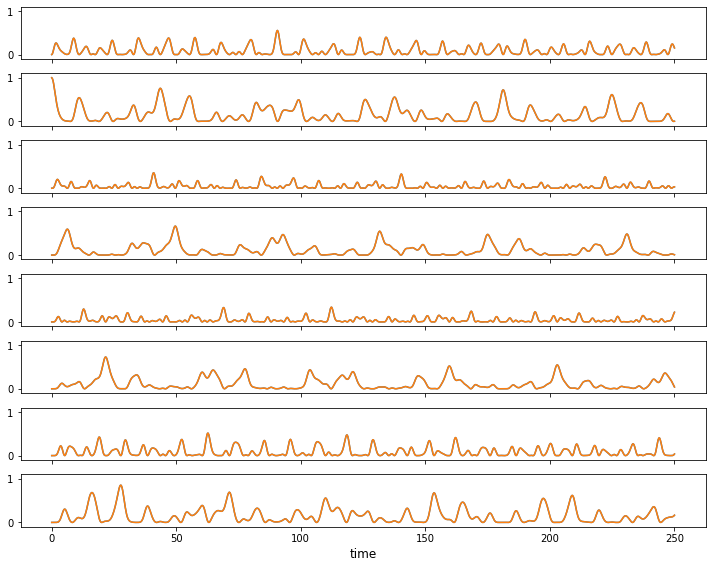

In [10]:
fig, axes = plot_expectation_values([result1, result2], figsize=(10, 8))
for ax in axes[:, 0]:
    ax.set_ylim(-0.1, 1.1)
fig.tight_layout();

In [11]:

def ENR_ptrace(rho, sel, excitations):
    """
    Partial trace for ENR states.   
    Parameters
    ----------
    rho : Qobj
        Qobj of an ENR system defined through  enr_fock enr_identity enr_thermal_dm enr_destroy or output from a solver
        
    sel : int/list
            An ``int`` or ``list`` of components to keep after partial trace.  
        
    excitations : integer
        The maximum number of excitations that are to be included in the
        state space.  Should be consistent with the same assumptions used to construct rho.
    
    Returns
    -------
    oper : qobj
        Quantum object representing partial trace with selected components
        remaining.
    
    Notes
    -----
    The default Qobj.ptrace() will fail with ENR systems.  This should be used instead.
    
    """
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)

    if (sel < 0).any() or (sel >= len(rho.dims[0])).any():
        raise TypeError("Invalid selection index in ptrace.")
    
    drho=rho.dims[0]
    
    ############
    #dimensions
    ####################
    #enr definitions for the original state
    nstates, state2idx, idx2state = enr_state_dictionaries(drho, excitations)
    

    
    ################
    #definition of number of states in selection
    ######################
    #
    
    dims_short= np.asarray(drho).take(sel)
    nstates2, state2idx2, idx2state2 = enr_state_dictionaries(dims_short.tolist(), excitations)

    
    # this is a list of the dimensions of the system one has traced out
    rest = np.setdiff1d(np.arange(len(drho)), sel)
    
       
    #construct matrix to return the new Density matrix
    rhout = np.zeros((nstates2,nstates2),dtype=np.complex64)
    
    for ind,state in enumerate(idx2state):
        for ind2,state2 in enumerate(idx2state):
            #if the parts of the states of the systems(s) being traced out are diagonal, add this to the new DM
            if  np.all(np.asarray(state).take(rest) == np.asarray(state2).take(rest)):

                rhout[state2idx2[tuple(np.asarray(state).take(sel))],
                      state2idx2[tuple(np.asarray(state2).take(sel))]] += rho.data[state2idx[state],
                                                                                    state2idx[state2]]
                
    
    dims_kept0 = np.asarray(drho).take(sel)
    rho1_dims = [dims_kept0.tolist(), dims_kept0.tolist()]
    rho1_shape = [nstates2, nstates2]
    
    return Qobj(rhout,rho1_dims,rho1_shape)
        

In [12]:
result1.states[10].ptrace([0]) 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.79900632 0.        ]
 [0.         0.20099368]]

In [13]:
ENR_ptrace(result2.states[10], [0], excitations)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.79899788 0.        ]
 [0.         0.20100211]]

In [14]:
result1.states[10].ptrace([0,1,4])


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.41175019+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.12056176+0.j          0.        +0.17930244j
   0.        +0.j         -0.15566411+0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        -0.17930244j  0.26669437+0.j
   0.        +0.j          0.        +0.23152687j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.15566411+0.j          0.        -0.23152687j
   0.        +0.j          0.20099368+0.j          0.        +0.j
   0.        +0.j 

In [15]:

ENR_ptrace(result2.states[10],[0,1,4],excitations)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.41175619+0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.1205487 +0.j          0.        +0.1793023j
  -0.15566093+0.j        ]
 [ 0.        +0.j          0.        -0.1793023j   0.26669303+0.j
   0.        +0.23152943j]
 [ 0.        +0.j         -0.15566093+0.j          0.        -0.23152943j
   0.20100211+0.j        ]]